In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/VAE, GAN & Diffusion Model on MNIST Dataset"

import os
print("📂 Current directory:", os.getcwd())
!apt install tree -y
!tree -L 2 -a --dirsfirst

Mounted at /content/drive
/content/drive/MyDrive/VAE, GAN & Diffusion Model on MNIST Dataset
📂 Current directory: /content/drive/MyDrive/VAE, GAN & Diffusion Model on MNIST Dataset
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 41 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 0s (137 kB/s)
Selecting previously unselected package tree.
(Reading database ... 121703 files and directories currently installed.)
Preparing to unpack .../tree_2.0.2-1_amd64.deb ...
Unpacking tree (2.0.2-1) ...
Setting up tree (2.0.2-1) ...
Processing triggers for man-db (2.10.2-1) ...
.
├── data
│   └── MNIST
├── MVP_Model
│   ├── GAN_mvp
│   └── VAE_mvp
└── Notebook
    ├── GAN_Train.ipynb

In [ ]:
import os, numpy as np
import torch, torch.nn as nn, torch.nn.functional as F, torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# I. Dataset Preparation

In [ ]:
batch_size = 128

# MNIST Dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# II. Model

## 1. Definition

In [ ]:
class VAE(nn.Module):
    def __init__(self, image_size, hidden_dim, latent_dim):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(image_size, hidden_dim)
        self.fc2_mean = nn.Linear(hidden_dim, latent_dim)
        self.fc2_logvar = nn.Linear(hidden_dim, latent_dim)
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, image_size)

    def encode(self, x):
        # Input x: [batch_size, 1, 28, 28]
        # Output mu, logvar: [batch_size, latent_dim]
        h = F.relu(self.fc1(x))
        mu = self.fc2_mean(h)
        logvar = self.fc2_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(logvar/2)
        eps = torch.randn_like(std)
        return mu + eps * std # [batch_size, latent_dim]

    def decode(self, z):
        h = F.relu(self.fc3(z))
        out = torch.sigmoid(self.fc4(h))
        return out

    def forward(self, x):
        # x: [batch_size, 1, 28, 28] -> [batch_size, 784]
        mu, logvar = self.encode(x.view(-1, image_size))
        # mu, logvar: [batch_size, latent_dim]

        z = self.reparameterize(mu, logvar)
        # z: [batch_size, latent_dim]

        reconstructed = self.decode(z)
        # reconstructed: [batch_size, image_size]

        return reconstructed, mu, logvar

In [ ]:
image_size = 784
hidden_dim = 400
latent_dim = 20
epochs = 50

In [ ]:
model = VAE(image_size=image_size, hidden_dim=hidden_dim, latent_dim=latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

## 2. Training

### 2.1 Loss function

\begin{align}
 \textrm{Loss} &= -E\left [ \textrm{log } \textrm{P}\left ( X|z \right ) \right ] + D_{KL}\left [\: N\left ( \mu (X), \sum (X) \right | N\left ( 0,1 \right ) ) \right ], \quad \\
                &\textrm{where } D_{KL}\left [\: N\left ( \mu (X), \sum (X) \right | N\left ( 0,1 \right ) ) \right ]
                = \frac{1}{2} \sum \left [ \textrm{exp}\left ( \sum (X) \right ) + \mu ^2\left ( X \right ) - 1 - \sum \left ( X \right ) \right ]
\end{align}

In [ ]:
def loss_function(reconstructed_image, original_image, mu, log_var):
    bce = F.binary_cross_entropy(reconstructed_image, original_image.view(-1, 784), reduction = "sum")
    kld = 0.5 * torch.sum(log_var.exp() + mu.pow(2) - 1 - log_var)
    return bce + kld

### 2.2 Training function

In [ ]:
def train(epoch, train_loader, model, loss_function, optimizer, device="cpu"):
    model = model.to(device)

    model.train()
    train_loss = 0

    for i, (images, _) in enumerate(train_loader):
        images = images.to(device)
        reconstructed, mu, logvar = model(images) # require_grad = True already !
        loss = loss_function(reconstructed, images, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        if i % 100 == 0: print("Train Epoch: {} [{}/{}]\tLoss: {:.3f}".format(epoch, i, len(train_loader), loss.item()/len(images)))

    print("=====> Epoch {} with average loss: {:.3f}".format(epoch, train_loss/len(train_loader.dataset)))
    return train_loss/len(train_loader.dataset)

In [ ]:
save_dir = "./MVP_Model/VAE_mvp"
os.makedirs(save_dir, exist_ok=True)

In [ ]:
loss_list = []
best_loss = float("inf")

for epoch in range(1, epochs+1):
    loss_curr_epoch = train(epoch, train_loader, model, loss_function, optimizer)
    loss_list.append(loss_curr_epoch)

    if best_loss < loss_curr_epoch:
        best_loss = loss_curr_epoch
        torch.save(model.state_dict(), os.path.join(save_dir, "best_vae.pth"))

Train Epoch: 1 [0/469]	Loss: 550.424
Train Epoch: 1 [100/469]	Loss: 189.258
Train Epoch: 1 [200/469]	Loss: 155.736
Train Epoch: 1 [300/469]	Loss: 142.306
Train Epoch: 1 [400/469]	Loss: 131.125
=====> Epoch 1 with average loss: 165.970
Train Epoch: 2 [0/469]	Loss: 130.122
Train Epoch: 2 [100/469]	Loss: 122.869
Train Epoch: 2 [200/469]	Loss: 121.735
Train Epoch: 2 [300/469]	Loss: 121.503
Train Epoch: 2 [400/469]	Loss: 118.410
=====> Epoch 2 with average loss: 121.875
Train Epoch: 3 [0/469]	Loss: 119.162
Train Epoch: 3 [100/469]	Loss: 117.648
Train Epoch: 3 [200/469]	Loss: 121.981
Train Epoch: 3 [300/469]	Loss: 114.445
Train Epoch: 3 [400/469]	Loss: 109.606
=====> Epoch 3 with average loss: 114.794
Train Epoch: 4 [0/469]	Loss: 109.232
Train Epoch: 4 [100/469]	Loss: 109.291
Train Epoch: 4 [200/469]	Loss: 110.469
Train Epoch: 4 [300/469]	Loss: 107.830
Train Epoch: 4 [400/469]	Loss: 109.870
=====> Epoch 4 with average loss: 111.758
Train Epoch: 5 [0/469]	Loss: 105.796
Train Epoch: 5 [100/469

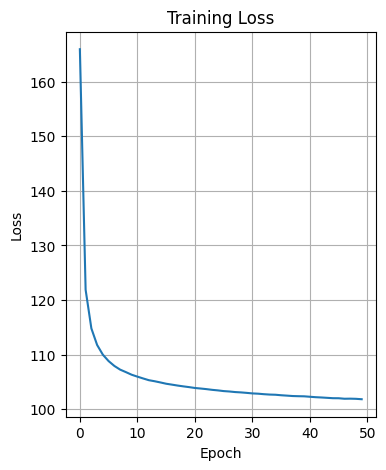

In [ ]:
fig, axs = plt.subplots(figsize=(4,5))

axs.plot(loss_list)
axs.set_xlabel("Epoch")
axs.set_ylabel("Loss")
axs.set_title("Training Loss")
axs.grid(True)

plt.show()

# II. Model testing

In [ ]:
save_dir = "./MVP_Model/VAE_mvp"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

image_size = 784
hidden_dim = 400
latent_dim = 20
vae_test = VAE(image_size=image_size, hidden_dim=hidden_dim, latent_dim=latent_dim)
vae_state = torch.load(os.path.join(save_dir, "best_vae.pth"))
vae_test.load_state_dict(vae_state)
vae_test.to(device)
vae_test.eval()

VAE(
  (fc1): Linear(in_features=784, out_features=400, bias=True)
  (fc2_mean): Linear(in_features=400, out_features=20, bias=True)
  (fc2_logvar): Linear(in_features=400, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=400, bias=True)
  (fc4): Linear(in_features=400, out_features=784, bias=True)
)

In [ ]:
z_list = []
label_list = []

vae_test.eval()
with torch.no_grad():
    for imgs, labels in test_loader:
        mask = (labels == 1) | (labels == 4) | (labels == 7)
        if mask.any():
            imgs = imgs[mask].to(device)
            labels_masked = labels[mask].numpy()

            mu, logvar = vae_test.encode(imgs.view(imgs.size(0), -1))
            z = vae_test.reparameterize(mu, logvar)
            z_list.append(z.cpu().numpy())
            label_list.append(labels_masked)

Z = np.concatenate(z_list, axis=0)
labels = np.concatenate(label_list, axis=0)

In [ ]:
print(Z.shape)
print(labels.shape)

(3145, 20)
(3145,)


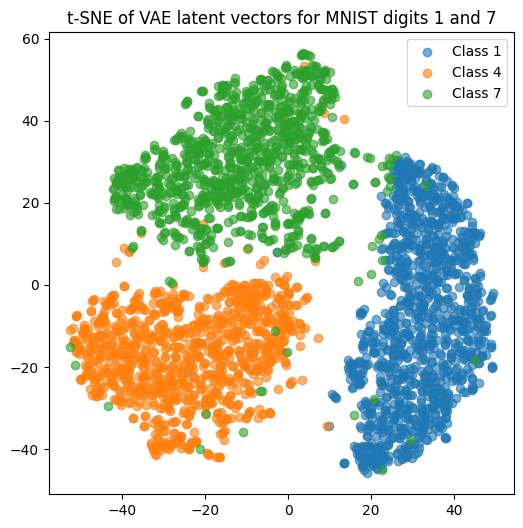

In [ ]:
# --- t-SNE ---
tsne = TSNE(n_components=2, random_state=42)
Z_tsne = tsne.fit_transform(Z)

# --- Visualization ---
plt.figure(figsize=(6,6))
for cls in [1,4,7]:
    idxs = labels == cls
    plt.scatter(Z_tsne[idxs,0], Z_tsne[idxs,1], label=f'Class {cls}', alpha=0.6)
plt.legend()
plt.title('t-SNE of VAE latent vectors for MNIST digits 1 and 7')
plt.show()